# Disaster Tweet Classification using RNN

## Setup

In [ ]:
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Reading the input data file

In [ ]:
df = pd.read_csv("train.csv")
# pd.read_csv(file_path, header=None, usecols=[3,6])
df = df.drop(["id", "keyword","location"], axis = 1)
# df.columns = [] * len(df.columns)
# df.to_csv('train.csv', header=False, index=False)
# df = df.iloc[1: , :]
# print(df.head(10))
# target=df.pop("target")
# print(type(target))
# print(target)
dataset = tf.data.Dataset.from_tensor_slices(dict(df))

# train_dataset, test_dataset = dataset['train'], dataset['test']
# print(train_dataset.take(2))
# for x in test_dataset.take(5):
#   print(x)
df.head()

In [ ]:
dataset_list=[]
for x in dataset.take(len(dataset)+1):
  x=tuple(x.values())
  dataset_list.append(x)

In [ ]:
l=[]
m=[]
for x,y in dataset_list:
  l.append(x.numpy())
  m.append(y.numpy())


In [ ]:
dataset1= tf.data.Dataset.from_tensor_slices((l,m))

In [ ]:
train_dataset = dataset1.take(5710)
test_dataset = dataset1.skip(5710)

In [ ]:
print(len(dataset1))

7613


In [ ]:
for x in dataset1.take(5):
  print(x)

(<tf.Tensor: shape=(), dtype=string, numpy=b'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'>, <tf.Tensor: shape=(), dtype=int32, numpy=1>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'Forest fire near La Ronge Sask. Canada'>, <tf.Tensor: shape=(), dtype=int32, numpy=1>)
(<tf.Tensor: shape=(), dtype=string, numpy=b"All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected">, <tf.Tensor: shape=(), dtype=int32, numpy=1>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'13,000 people receive #wildfires evacuation orders in California '>, <tf.Tensor: shape=(), dtype=int32, numpy=1>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school '>, <tf.Tensor: shape=(), dtype=int32, numpy=1>)


Initially this returns a dataset of (text, label pairs):

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'
label:  1


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'To fight bioterrorism sir.'
 b'I hope it rains throughout the whole weekend I hope it floods and the portaloos become sentient.'
 b'I had no issues uploading DEATH TO SMOOCHY or AWAKENINGS clips to @YouTube but for some reason BICENTENNIAL MAN is being a pain in the ass.']

labels:  [0 0 0]


## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'to', 'a', 'in', 'of', 'and', 'i', 'is', 'on',
       'for', 'you', 'my', 'with', 'it', 'that', 'by', 'at', 'this'],
      dtype='<U13')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  3, 698, 523,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [  8, 264,  15,   1,   1,   2, 514,   1,   8, 264,  15, 156,   7,
          2,   1, 945,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [  8,  85,  38, 520,   1, 135,   3,   1,  53,   1,   1,   3, 108,
         32,  11, 103, 767,   1,  90,   9, 111,   4, 875,   5,   2, 249,
          0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'To fight bioterrorism sir.'
Round-trip:  to fight bioterrorism [UNK]                       

Original:  b'I hope it rains throughout the whole weekend I hope it floods and the portaloos become sentient.'
Round-trip:  i hope it [UNK] [UNK] the whole [UNK] i hope it floods and the [UNK] become [UNK]          

Original:  b'I had no issues uploading DEATH TO SMOOCHY or AWAKENINGS clips to @YouTube but for some reason BICENTENNIAL MAN is being a pain in the ass.'
Round-trip:  i had no issues [UNK] death to [UNK] or [UNK] [UNK] to youtube but for some reason [UNK] man is being a pain in the ass 



## Create the model

![A drawing of the information flow in the model](images/bidirectional.png)

Above is a diagram of the model.

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output.


The code to implement this is below:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [ ]:
# predict on a sample text without padding.

sample_text = ('Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.00633043]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.00633043]


Compile the Keras model to configure the training process:

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [ ]:
history = model.fit(train_dataset, epochs=30,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
90/90 [==============================] - 17s 67ms/step - loss: 0.6875 - accuracy: 0.5772 - val_loss: 0.6903 - val_accuracy: 0.5497
Epoch 2/10
90/90 [==============================] - 3s 33ms/step - loss: 0.6720 - accuracy: 0.5772 - val_loss: 0.6800 - val_accuracy: 0.5497
Epoch 3/10
90/90 [==============================] - 3s 33ms/step - loss: 0.5954 - accuracy: 0.6342 - val_loss: 0.5732 - val_accuracy: 0.6752
Epoch 4/10
90/90 [==============================] - 3s 33ms/step - loss: 0.5008 - accuracy: 0.7618 - val_loss: 0.5652 - val_accuracy: 0.6742
Epoch 5/10
90/90 [==============================] - 3s 33ms/step - loss: 0.4597 - accuracy: 0.7862 - val_loss: 0.5376 - val_accuracy: 0.6994
Epoch 6/10
90/90 [==============================] - 3s 34ms/step - loss: 0.4367 - accuracy: 0.8025 - val_loss: 0.5959 - val_accuracy: 0.6810
Epoch 7/10
90/90 [==============================] - 3s 34ms/step - loss: 0.4134 - accuracy: 0.8144 - val_loss: 0.5308 - val_accuracy: 0.7168
Epoch 8/10
9

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

30/30 [==============================] - 0s 11ms/step - loss: 0.5414 - accuracy: 0.7194
Test Loss: 0.5413621068000793
Test Accuracy: 0.7193904519081116


(0.0, 0.7059419617056847)

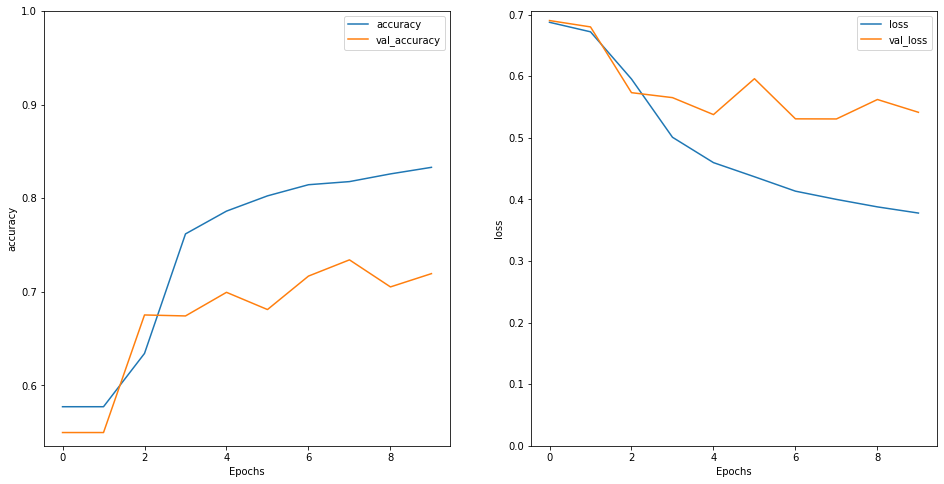

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is real disaster tweet else it is a fake one.

In [ ]:
sample_text = ('Earthquake')
predictions = model.predict(np.array([sample_text]))

In [ ]:
if predictions>=0.0 :
  print("Its a Real Disaster Tweet")
else:
  print("Its a Fake Disaster Tweet")

Its a Real Disaster Tweet


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](images/layered_bidirectional.png)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
90/90 [==============================] - 30s 132ms/step - loss: 0.6859 - accuracy: 0.5772 - val_loss: 0.6902 - val_accuracy: 0.5497
Epoch 2/10
90/90 [==============================] - 5s 54ms/step - loss: 0.6679 - accuracy: 0.5772 - val_loss: 0.6646 - val_accuracy: 0.5497
Epoch 3/10
90/90 [==============================] - 5s 55ms/step - loss: 0.6005 - accuracy: 0.5848 - val_loss: 0.5875 - val_accuracy: 0.5933
Epoch 4/10
90/90 [==============================] - 5s 55ms/step - loss: 0.5006 - accuracy: 0.7494 - val_loss: 0.5461 - val_accuracy: 0.6910
Epoch 5/10
90/90 [==============================] - 5s 56ms/step - loss: 0.4504 - accuracy: 0.7988 - val_loss: 0.5309 - val_accuracy: 0.7204
Epoch 6/10
90/90 [==============================] - 5s 54ms/step - loss: 0.4277 - accuracy: 0.8145 - val_loss: 0.5255 - val_accuracy: 0.7378
Epoch 7/10
90/90 [==============================] - 5s 54ms/step - loss: 0.4073 - accuracy: 0.8263 - val_loss: 0.5320 - val_accuracy: 0.7336
Epoch 8/10


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

30/30 [==============================] - 1s 26ms/step - loss: 0.5389 - accuracy: 0.7310
Test Loss: 0.538948655128479
Test Accuracy: 0.7309511303901672


In [ ]:
# predict on a sample text without padding.

sample_text = ('Im a gangsta')
predictions = model.predict(np.array([sample_text]))

In [ ]:
if predictions>=0.0 :
  print("Its a Real Disaster Tweet")
else:
  print("Its a Fake Disaster Tweet")

Its a Fake Disaster Tweet


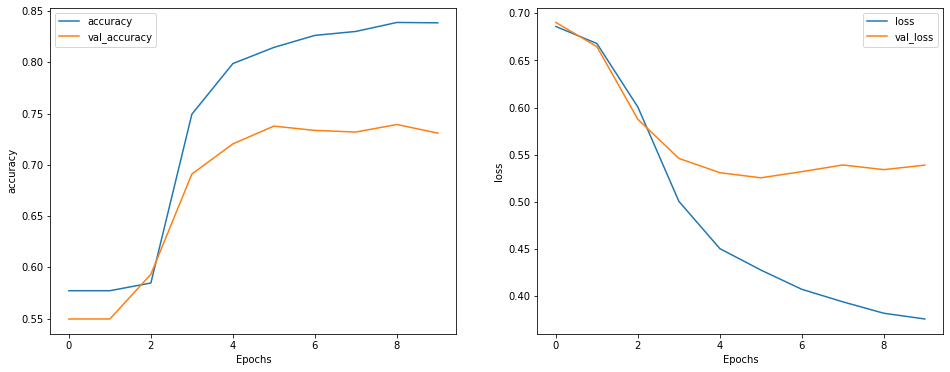

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')